In [ ]:
pip install sgp4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.3/232.3 kB 6.1 MB/s eta 0:00:00


In [ ]:
pip install sgp4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.3/232.3 kB 5.3 MB/s eta 0:00:00


In [ ]:
pip install basemap basemap-data-hires


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 936.0/936.0 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


Elementos Orbitais:
   Semi-eixo Maior Verdadeiro (km)  Semi-eixo Maior Estimado (km)  \
0                      6963.381254                    6960.505542   
1                      6963.381255                    6960.823745   
2                      6963.381256                    6964.618102   
3                      6963.381257                    6967.885860   
4                      6963.381258                    6969.590588   

   Diferença Semi-eixo Maior (km)  Excentricidade Verdadeira  \
0                        2.875713                   0.000965   
1                        2.557510                   0.000965   
2                       -1.236846                   0.000965   
3                       -4.504603                   0.000965   
4                       -6.209330                   0.000965   

   Excentricidade Estimada  Diferença Excentricidade  \
0                 0.008765                 -0.007799   
1                 0.014095                 -0.013130   
2           

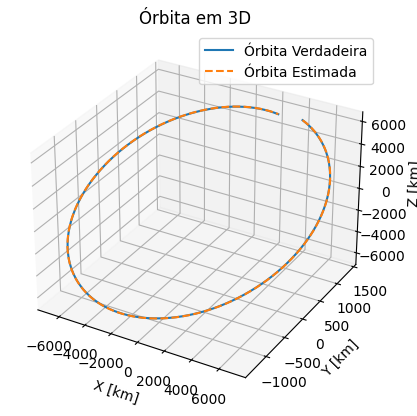

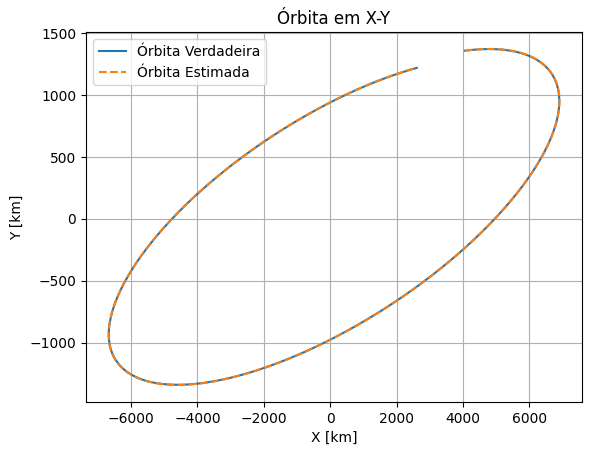

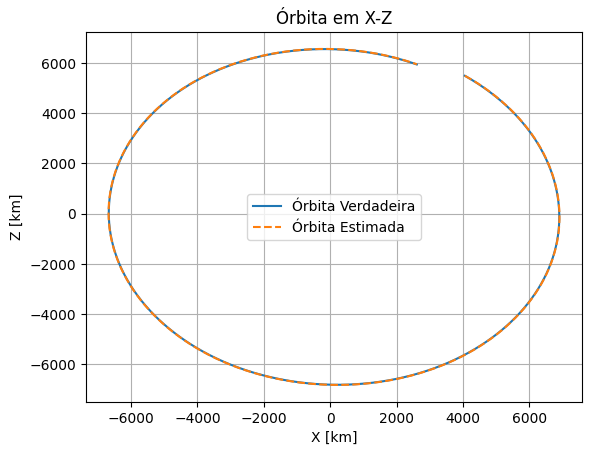

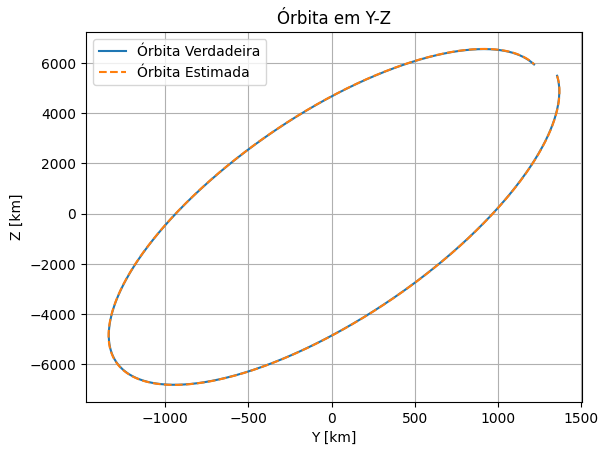

Tempo de execução: 6.504783710000083 segundos


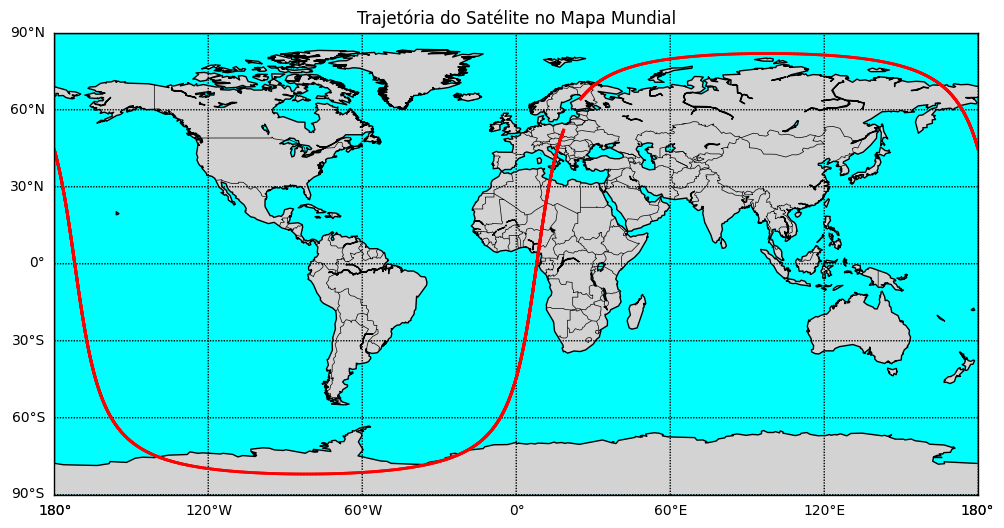

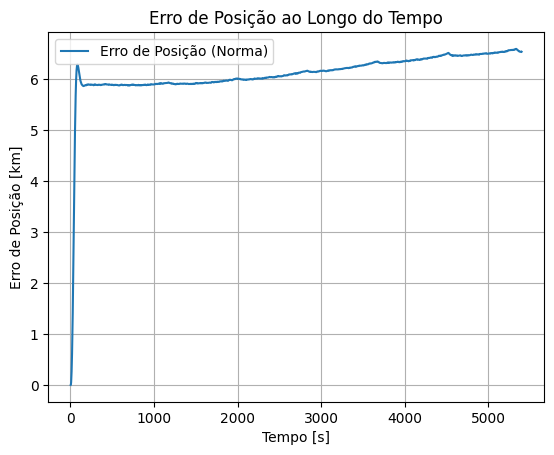

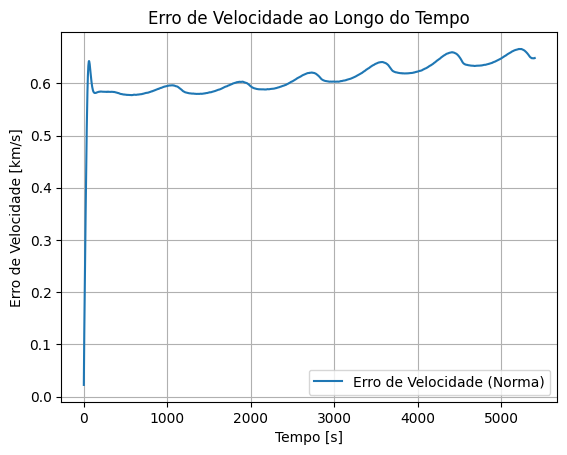

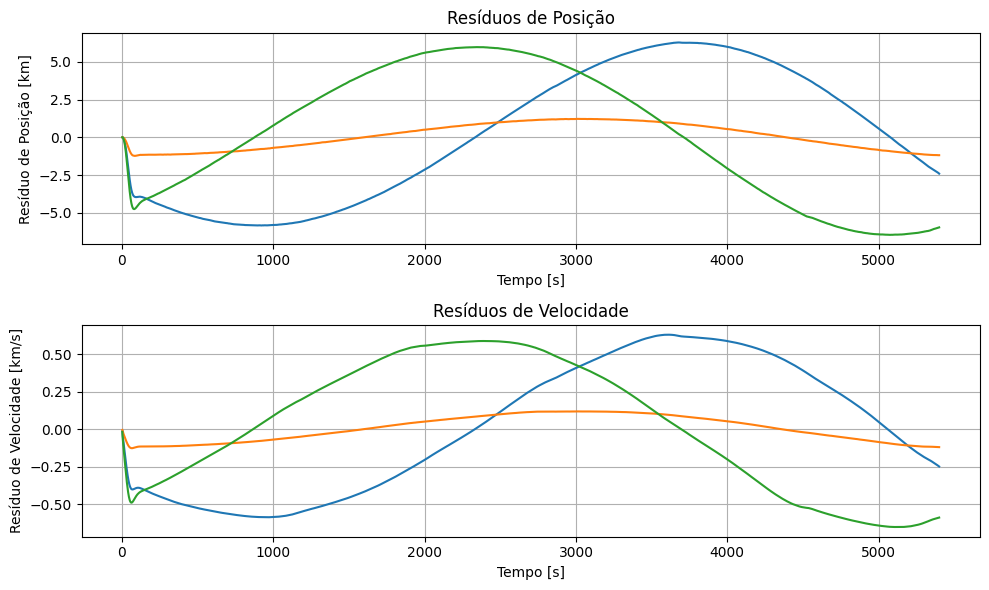

RMSE de Posição: [4.32696197 0.83482193 4.27503302]
RMSE de Velocidade: [0.42983163 0.08327666 0.42606362]


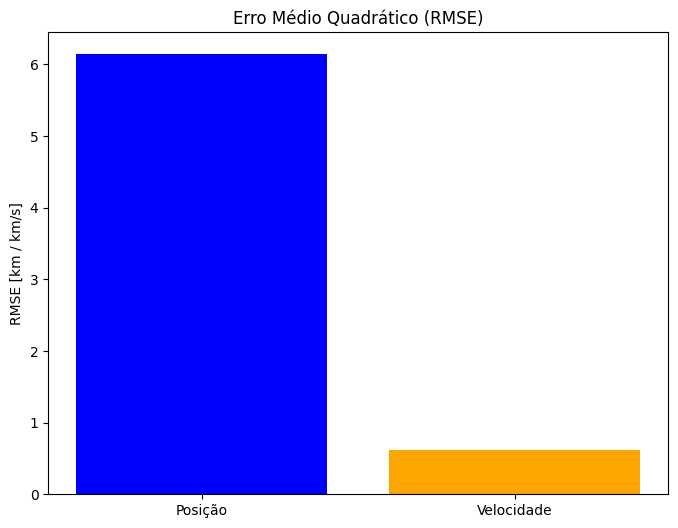

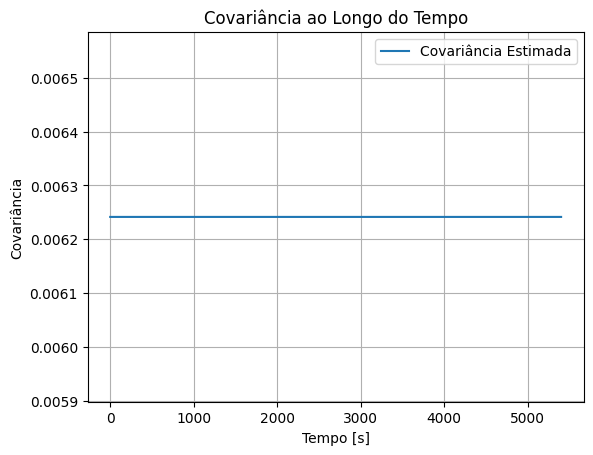

In [ ]:
import time
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from numpy.linalg import inv
import pandas as pd
from sgp4.api import Satrec, jday
from sgp4.api import Satrec
from mpl_toolkits.basemap import Basemap

start_time = time.perf_counter()
# Função para converter TLE para posição e velocidade inicial
def tle_to_state_vector(tle_line1, tle_line2, epoch):
    # Criando o objeto Satrec a partir do TLE
    satellite = Satrec.twoline2rv(tle_line1, tle_line2)

    # Convertendo o tempo para dia juliano
    jd, fr = jday(epoch.year, epoch.month, epoch.day, epoch.hour, epoch.minute, epoch.second)

    # Calculando a posição e a velocidade (em km e km/s)
    e, r, v = satellite.sgp4(jd, fr)

    if e != 0:
        raise ValueError("Erro no cálculo da posição e velocidade a partir do TLE")

    return np.array(r), np.array(v)

# Parâmetros do problema (em km)
mu = 3.986004418e5  # Constante gravitacional da Terra [km^3/s^2]


# Insira os elementos TLE aqui
tle_line1 = '1 40024U 14033Q   24233.47021434  .00021172  00000+0  14824-2 0  9993'
tle_line2 = '2 40024  98.0686 208.3352 0003903 334.8007  25.3027 15.05266028552918'

# Definindo a época de interesse (data e hora)
from datetime import datetime
epoch = datetime(2023, 8, 18, 0, 0, 0)  # Ajuste a data/hora conforme necessário

# Calculando a posição e a velocidade a partir do TLE
r0, v0 = tle_to_state_vector(tle_line1, tle_line2, epoch)

# Função de arraste atmosférico
def atmospheric_drag(v, r, Cd=2.2, A=20, m=500, rho=1e-12):
    v_rel = np.linalg.norm(v)
    drag_force = -0.5 * Cd * A * rho * v_rel * v / m
    return drag_force

# Função de pressão da radiação solar
def solar_radiation_pressure(r, A=20, m=500, Psr=4.5e-6):
    r_norm = np.linalg.norm(r)
    srp_force = Psr * A / m * r / r_norm
    return srp_force

# Função de dinâmica com perturbações (modelo perturbado)
def perturbed_dynamics(t, y):
    r = y[:3]
    v = y[3:]
    r_norm = np.linalg.norm(r)
    a_gravity = -mu * r / r_norm**3
    a_drag = atmospheric_drag(v, r)
    a_srp = solar_radiation_pressure(r)
    return np.hstack((v, a_gravity + a_drag + a_srp))

# Função para calcular o Jacobiano da dinâmica (F)
def jacobian_F(x, dt):
    r = x[:3]
    v = x[3:]
    r_norm = np.linalg.norm(r)

    # Derivadas parciais da aceleração em relação à posição (Jacobian de a_gravity)
    dadr = mu * (3 * np.outer(r, r) / r_norm**5 - np.eye(3) / r_norm**3)

    # Montagem da matriz F (Jacobian da dinâmica)
    F = np.eye(6)
    F[:3, 3:] = np.eye(3) * dt  # dv/dt = a
    F[3:, :3] = dadr * dt       # dr/dt = v

    return F

# Função para calcular os elementos orbitais
def orbital_elements(r, v):
    h = np.cross(r, v)  # Momento angular específico
    h_norm = np.linalg.norm(h)

    # Semi-eixo maior (a)
    r_norm = np.linalg.norm(r)
    v_norm = np.linalg.norm(v)
    energy = v_norm**2 / 2 - mu / r_norm
    a = -mu / (2 * energy)

    # Excentricidade (e)
    e_vec = (1/mu) * (np.cross(v, h) - mu * r / r_norm)
    e = np.linalg.norm(e_vec)

    # Inclinação (i)
    i = np.arccos(h[2] / h_norm)

    # Nodo ascendente (Ω)
    K = np.array([0, 0, 1])  # Eixo Z
    n_vec = np.cross(K, h)
    n_norm = np.linalg.norm(n_vec)
    if n_norm != 0:
        Ω = np.arccos(n_vec[0] / n_norm)
        if n_vec[1] < 0:
            Ω = 2 * np.pi - Ω
    else:
        Ω = 0

    # Argumento do periapsis (ω)
    if e != 0:
        ω = np.arccos(np.dot(n_vec, e_vec) / (n_norm * e))
        if e_vec[2] < 0:
            ω = 2 * np.pi - ω
    else:
        ω = 0

    # Anomalia verdadeira (ν)
    if e != 0:
        ν = np.arccos(np.dot(e_vec, r) / (e * r_norm))
        if np.dot(r, v) < 0:
            ν = 2 * np.pi - ν
    else:
        ν = 0

    return a, e, i, Ω, ω, ν

# Tempo de simulação
t_span = (0, 5400)  # 90 minutos
t_eval = np.linspace(0, 5400, 2000)  # Aumentamos a resolução para melhorar a precisão

# Integração numérica para simular a órbita com perturbações
y0 = np.hstack((r0, v0))
sol_perturbed = integrate.solve_ivp(perturbed_dynamics, t_span, y0, t_eval=t_eval)

r_perturbed = sol_perturbed.y[:3].T  # Posição perturbada
v_perturbed = sol_perturbed.y[3:].T  # Velocidade perturbada

# Inicialização do EKF

x_est = np.zeros((len(t_eval), 6))  # Posição e velocidade estimadas
x_est[0] = np.hstack((r0, v0))  # Estimativa inicial próxima da verdadeira
P_est = np.eye(6) * 1e-3  # Covariância inicial ajustada para menor incerteza

# Matrizes de Covariância (R e Q) ajustadas
R = np.eye(6) * 1e-2  # Covariância de medição (ajustada para ruído moderado)
Q = np.eye(6) * 1e-6  # Covariância do processo (ajustada para pequenas perturbações)

# Função de predição do estado com Jacobiano
def predict(x, P, dt):
    # Predição do estado usando a dinâmica com perturbações
    F = jacobian_F(x, dt)  # Jacobiano da dinâmica
    x_pred = F @ x
    P_pred = F @ P @ F.T + Q
    return x_pred, P_pred

# Função de correção com medidas de GPS e IMU
def correct(x_pred, P_pred, z_meas):
    H = np.eye(6)  # Matriz de medição (identidade para medições diretas de posição e velocidade)
    K = P_pred @ H.T @ inv(H @ P_pred @ H.T + R)  # Ganho de Kalman
    x_corr = x_pred + K @ (z_meas - H @ x_pred)
    P_corr = (np.eye(6) - K @ H) @ P_pred
    return x_corr, P_corr

# Simulando o ruído reduzido nas medições
noise_std = 1e-2  # Reduzimos o desvio padrão do ruído para melhorar a estimativa

# Loop do EKF com Jacobianos
elements_perturbed = []
elements_estimated = []
elements_diff = []
positions_diff = []
for i in range(1, len(t_eval)):
    dt = t_eval[i] - t_eval[i - 1]
    x_pred, P_pred = predict(x_est[i - 1], P_est, dt)


    # Simulando a medida com ruído reduzido
    z_meas = np.hstack((r_perturbed[i], v_perturbed[i])) + np.random.randn(6) * noise_std

    x_corr, P_corr = correct(x_pred, P_pred, z_meas)
    x_est[i] = x_corr
    P_est = P_corr

    # Cálculo dos elementos orbitais para a órbita perturbada e estimada
    a_perturbed, e_perturbed, i_perturbed, Ω_perturbed, ω_perturbed, ν_perturbed = orbital_elements(r_perturbed[i], v_perturbed[i])
    a_est, e_est, i_est, Ω_est, ω_est, ν_est = orbital_elements(x_est[i][:3], x_est[i][3:])

    elements_perturbed.append([a_perturbed, e_perturbed, i_perturbed, Ω_perturbed, ω_perturbed, ν_perturbed])
    elements_estimated.append([a_est, e_est, i_est, Ω_est, ω_est, ν_est])

    # Calculando as diferenças dos elementos orbitais
    elements_diff.append([
        a_perturbed - a_est,
        e_perturbed - e_est,
        i_perturbed - i_est,
        Ω_perturbed - Ω_est,
        ω_perturbed - ω_est,
        ν_perturbed - ν_est
    ])

    # Calculando as diferenças de posição
    positions_diff.append(r_perturbed[i] - x_est[i][:3])

# Convertendo para DataFrame para exibição dos elementos orbitais
elements_df = pd.DataFrame({
    "Semi-eixo Maior Verdadeiro (km)": [el[0] for el in elements_perturbed],
    "Semi-eixo Maior Estimado (km)": [el[0] for el in elements_estimated],
    "Diferença Semi-eixo Maior (km)": [el[0] for el in elements_diff],
    "Excentricidade Verdadeira": [el[1] for el in elements_perturbed],
    "Excentricidade Estimada": [el[1] for el in elements_estimated],
    "Diferença Excentricidade": [el[1] for el in elements_diff],
    "Inclinação Verdadeira (rad)": [el[2] for el in elements_perturbed],
    "Inclinação Estimada (rad)": [el[2] for el in elements_estimated],
    "Diferença Inclinação (rad)": [el[2] for el in elements_diff],
    "Longitude do Nodo Ascendente Verdadeira (rad)": [el[3] for el in elements_perturbed],
    "Longitude do Nodo Ascendente Estimada (rad)": [el[3] for el in elements_estimated],
    "Diferença Longitude do Nodo Ascendente (rad)": [el[3] for el in elements_diff],
    "Argumento do Periapsis Verdadeiro (rad)": [el[4] for el in elements_perturbed],
    "Argumento do Periapsis Estimado (rad)": [el[4] for el in elements_estimated],
    "Diferença Argumento do Periapsis (rad)": [el[4] for el in elements_diff],
    "Anomalia Verdadeira (rad)": [el[5] for el in elements_perturbed],
    "Anomalia Estimada (rad)": [el[5] for el in elements_estimated],
    "Diferença Anomalia (rad)": [el[5] for el in elements_diff],
})

print("Elementos Orbitais:")
print(elements_df.head())

len_r_perturbed = len(r_perturbed)
len_x_est = len(x_est)
len_positions_diff = len(positions_diff)

# Encontrando o comprimento mínimo entre as listas
min_length = min(len_r_perturbed, len_x_est, len_positions_diff)

# Truncando todas as listas ao comprimento mínimo
r_perturbed = r_perturbed[:min_length]
x_est = x_est[:min_length]
positions_diff = positions_diff[:min_length]

# Convertendo para DataFrame para exibição das posições
positions_df = pd.DataFrame({
    "Posição X Verdadeira (km)": [pos[0] for pos in r_perturbed],
    "Posição Y Verdadeira (km)": [pos[1] for pos in r_perturbed],
    "Posição Z Verdadeira (km)": [pos[2] for pos in r_perturbed],
    "Posição X Estimada (km)": [pos[0] for pos in x_est[:, :3]],
    "Posição Y Estimada (km)": [pos[1] for pos in x_est[:, :3]],
    "Posição Z Estimada (km)": [pos[2] for pos in x_est[:, :3]],
    "Diferença X (km)": [diff[0] for diff in positions_diff],
    "Diferença Y (km)": [diff[1] for diff in positions_diff],
    "Diferença Z (km)": [diff[2] for diff in positions_diff],
})


print(positions_df.head())

# Gráfico 3D da Órbita
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Órbita verdadeira perturbada
ax.plot(r_perturbed[:, 0], r_perturbed[:, 1], r_perturbed[:, 2], label='Órbita Verdadeira')

# Órbita estimada
ax.plot(x_est[:, 0], x_est[:, 1], x_est[:, 2], label='Órbita Estimada', linestyle='--')

ax.set_xlabel('X [km]')
ax.set_ylabel('Y [km]')
ax.set_zlabel('Z [km]')
ax.legend()
plt.title('Órbita em 3D')
plt.show()

# Gráfico 2D da Órbita (X, Y)
plt.figure()
plt.plot(r_perturbed[:, 0], r_perturbed[:, 1], label='Órbita Verdadeira')
plt.plot(x_est[:, 0], x_est[:, 1], label='Órbita Estimada', linestyle='--')
plt.xlabel('X [km]')
plt.ylabel('Y [km]')
plt.legend()
plt.title('Órbita em X-Y')
plt.grid(True)
plt.show()

# Gráfico 2D da Órbita (X, Z)
plt.figure()
plt.plot(r_perturbed[:, 0], r_perturbed[:, 2], label='Órbita Verdadeira')
plt.plot(x_est[:, 0], x_est[:, 2], label='Órbita Estimada', linestyle='--')
plt.xlabel('X [km]')
plt.ylabel('Z [km]')
plt.legend()
plt.title('Órbita em X-Z')
plt.grid(True)
plt.show()

# Gráfico 2D da Órbita (Y, Z)
plt.figure()
plt.plot(r_perturbed[:, 1], r_perturbed[:, 2], label='Órbita Verdadeira')
plt.plot(x_est[:, 1], x_est[:, 2], label='Órbita Estimada', linestyle='--')
plt.xlabel('Y [km]')
plt.ylabel('Z [km]')
plt.legend()
plt.title('Órbita em Y-Z')
plt.grid(True)
plt.show()
end_time = time.perf_counter()
execution_time = end_time - start_time
print(f"Tempo de execução: {execution_time} segundos")



def cartesian_to_geographic(r):
    R_earth = 6371.0  # Raio da Terra em km
    lat = np.degrees(np.arcsin(r[:, 2] / np.linalg.norm(r, axis=1)))  # Latitude
    lon = np.degrees(np.arctan2(r[:, 1], r[:, 0]))  # Longitude
    return lat, lon

# Obtenha a latitude e longitude a partir das posições perturbadas (r_perturbed)
latitudes, longitudes = cartesian_to_geographic(r_perturbed)

# Criando o mapa e a figura fora do loop
plt.figure(figsize=(12, 6))
m = Basemap(projection='cyl', resolution='c')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgray', lake_color='aqua')
m.drawparallels(np.arange(-90., 91., 30.), labels=[True,False,False,False])
m.drawmeridians(np.arange(-180., 181., 60.), labels=[False,False,False,True])
m.drawmapboundary(fill_color='aqua')

# Plotando a trajetória do satélite com verificação de continuidade
for i in range(1, len(latitudes)):
    if abs(longitudes[i] - longitudes[i-1]) < 180:  # Verifica se não há salto grande em longitude
        m.plot([longitudes[i-1], longitudes[i]], [latitudes[i-1], latitudes[i]], 'r-', linewidth=2)

plt.title("Trajetória do Satélite no Mapa Mundial")
plt.show()




In [ ]:
pip install skyfield matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.2/336.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.9 MB/s eta 0:00:00


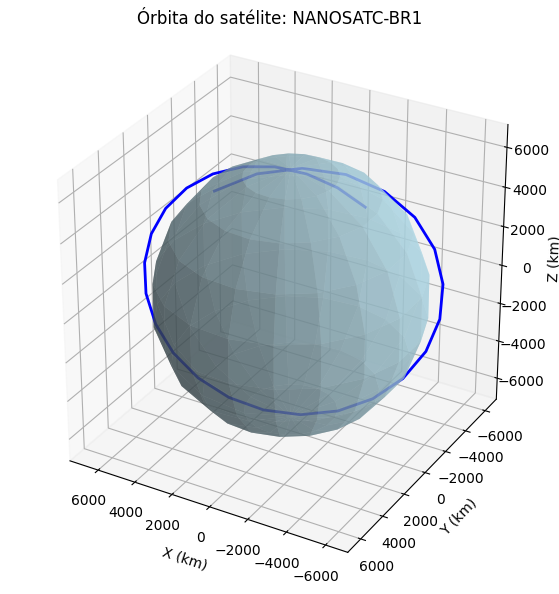

In [ ]:
from skyfield.api import Topos, load, EarthSatellite
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Dados TLE do NANOSATC-BR1
line1 = "1 40024U 14033Q   24231.47591853  .00022714  00000+0  15934-2 0  9994"
line2 = "2 40024  98.0677 206.2510 0004330 341.9831  18.1240 15.05178164553135"
satellite = EarthSatellite(line1, line2, 'NANOSATC-BR1', load.timescale())

# Definir a posição da Terra e o intervalo de tempo
ts = load.timescale()
t = ts.utc(2024, 8, range(0, 30, 1))  # Intervalo reduzido para 100 minutos

# Obter as coordenadas da órbita em 3D
geocentric = satellite.at(t)
x, y, z = geocentric.position.km  # Coordenadas em quilômetros

# Plotar a órbita em 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotar a Terra para referência (esfera)
r_earth = 6371  # Raio da Terra em km
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x_earth = r_earth * np.cos(u) * np.sin(v)
y_earth = r_earth * np.sin(u) * np.sin(v)
z_earth = r_earth * np.cos(v)
ax.plot_surface(x_earth, y_earth, z_earth, color='lightblue', alpha=0.6)

# Plotar a órbita do satélite
ax.plot(x, y, z, 'b-', linewidth=2)
ax.set_title(f'Órbita do satélite: NANOSATC-BR1')
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.grid(True)

# Alterar a perspectiva da visualização
ax.view_init(elev=30, azim=120)  # Ajusta o ângulo de visualização

# Para melhorar a visualização
ax.set_box_aspect([1,1,1])  # Escala os eixos igualmente

plt.show()

